In [78]:
import pandas as pd
import numpy as np
import pickle
from src.constants import *
from src.neuron import *
from src.utils import *
from src.network import *
from src.validation import *
from src.viz import *
from src.genetic_algorithm import *
from multiprocessing import Pool
from functools import partial
import ast

pkl_file = '/Users/stevenwendel/Documents/GitHub/bg/data/J_high_gen_2025-03-13_04-00-56.pkl'

with open(pkl_file, 'rb') as f: 
    ga_results = pickle.load(f)


In [4]:
initial_df = flatten_pkl(ga_results)


In [5]:
def clean_df(initial_df, threshold=700):
    print(f"Initial rows: {len(initial_df)}")
    
    # Create a copy after filtering to avoid chained indexing
    cleaned_df = initial_df[initial_df['dna_score'] >= threshold].copy()
    print(f"Rows after threshold filter: {len(cleaned_df)}")
    
    # Add tuple column to the copy
    cleaned_df.loc[:, 'dna_tuple'] = cleaned_df['dna'].apply(tuple)
    
    # Drop duplicates and create new copy
    cleaned_df = cleaned_df.drop_duplicates(subset='dna_tuple')
    print(f"Rows after removing duplicates: {len(cleaned_df)}")
    
    # Drop the temporary column and sort
    cleaned_df = cleaned_df.drop('dna_tuple', axis=1)
    cleaned_df = cleaned_df.sort_values(by='dna_score', ascending=False)    
    return cleaned_df

cleaned_df = clean_df(initial_df, threshold=728)

Initial rows: 500000
Rows after threshold filter: 4524
Rows after removing duplicates: 1647


In [6]:
def get_unique_representatives_efficient(df, max_synapses=20):
    """
    Returns a DataFrame with unique network topologies (binary connection patterns),
    keeping only configurations with max_synapses or fewer connections.
    For each unique topology, keeps the highest scoring representative.
    """
    # Convert DNA lists to numpy arrays for faster processing
    dna_arrays = np.array([np.array(dna) for dna in df['dna']])
    
    # Create binary masks (1 where weight exists, 0 where no connection)
    binary_patterns = (dna_arrays != 0).astype(int)
    
    # Count synapses in each configuration
    synapse_counts = np.sum(binary_patterns, axis=1)
    
    # Filter by number of synapses first
    mask = synapse_counts <= max_synapses
    filtered_df = df[mask].copy()
    filtered_patterns = binary_patterns[mask]
    
    # Convert binary patterns to tuples for hashing
    pattern_tuples = [tuple(pattern) for pattern in filtered_patterns]
    
    # Create dictionary to store highest scoring example of each pattern
    unique_patterns = {}
    for idx, pattern in enumerate(pattern_tuples):
        score = filtered_df.iloc[idx]['dna_score']
        if pattern not in unique_patterns or score > unique_patterns[pattern]['score']:
            unique_patterns[pattern] = {
                'index': filtered_df.index[idx],
                'score': score
            }
    
    # Get the indices of the highest scoring representative of each pattern
    unique_indices = [info['index'] for info in unique_patterns.values()]
    
    # Create final DataFrame with unique representatives
    result_df = df.loc[unique_indices].sort_values('dna_score', ascending=False)
    
    print(f"Found {len(result_df)} unique network topologies with {max_synapses} or fewer synapses")
    return result_df

cleaned_df = get_unique_representatives_efficient(cleaned_df, max_synapses=20)
display(cleaned_df.reset_index(drop=True))


Found 12 unique network topologies with 25 or fewer synapses


,generation,dna,dna_score
0,998,"[1000, 0, 0, 885, -8, 0, 0, 0, -43, 0, 0, 0, -...",738
1,878,"[999, 0, 0, 771, -87, 0, 0, 0, -27, 0, 0, 0, -...",737
2,896,"[159, 0, 0, 995, -7, -11, 0, 0, -8, 0, 0, 0, -...",736
3,855,"[999, 0, 0, 612, -14, -14, 0, 0, -10, 0, 0, 0,...",736
4,743,"[151, 0, 0, 1000, -14, 0, 0, 0, -9, 0, 0, 0, -...",732
5,739,"[473, 0, 0, 646, -23, -11, 0, 0, -167, 0, 0, 0...",732
6,888,"[998, 0, 0, 1000, 0, -16, 0, 0, -26, 0, 0, 0, ...",729
7,947,"[1000, 0, 0, 1000, 0, 0, 0, 0, -26, 0, 0, 0, -...",728
8,848,"[112, 0, 0, 149, 0, 0, 0, 0, -8, 0, 0, 0, -97,...",728
9,810,"[1000, 0, 0, 0, -27, -71, 0, 0, -8, 0, 0, 0, -...",728


In [7]:
def get_dna_score(curr_dna):
    dna_matrix = load_dna(curr_dna)
    
    # === Preparing Network === 
    all_neurons = create_neurons()
    splits, input_waves, alpha_array = create_experiment()
    criteria_dict = define_criteria()
    max_score = TMAX // BIN_SIZE * len(CRITERIA_NAMES)

    dna_score, neuron_data = evaluate_dna(
        dna_matrix=dna_matrix,
        neurons=all_neurons,
        alpha_array=alpha_array,
        input_waves=input_waves,
        criteria=criteria_dict,
        curr_dna=curr_dna
    )
    total_score = sum(dna_score.values())
    print(f'    === DNA: {curr_dna}') 
    print(f'    === Control: {dna_score["control"]}/{max_score}')
    print(f'    === Experimental: {dna_score["experimental"]}/{max_score}')
    print(f'    === Overall: {total_score}({total_score/(2*max_score):.2%})')
    print('\n')

    return total_score  # Random score for demonstration

In [ ]:
# del parent_dnas, children_dnas, seen_configurations, fully_reduced_dnas
parent_dnas = cleaned_df

fully_reduced_dnas = pd.DataFrame(columns=cleaned_df.columns)
min_score = 728
seen_configurations = set()

while parent_dnas.shape[0]>0:
    # Reporting
    print(f"A new day rises and the parents must be culled. The parents who have made it to the safe zone are:")
    display(fully_reduced_dnas)
    print("The current parents:")
    display(parent_dnas)
    print("seen configurations")
    print(seen_configurations)

    # Create empty df to collect new dnas
    children_dnas = pd.DataFrame(columns=cleaned_df.columns)

    for index, row in parent_dnas.iterrows():
        print(f'Working on row {index}')
        dna_children=0
        parent_dna = row['dna']
        parent_score = row['dna_score']

        dna_tuple = tuple(parent_dna)
        # Skip if we've seen this configuration before
        if dna_tuple in seen_configurations:
            continue
        seen_configurations.add(dna_tuple)

        for i in range(len(parent_dna)):
            if parent_dna[i] != 0:
                child_dna = parent_dna.copy()
                child_dna[i]=0
                # new_dna_tuple = tuple(child_dna)
                # new_score = np.random.normal(row['dna_score'], 5, 1)
        
                child_score = get_dna_score(child_dna)
                if child_score > min_score:
                    children_dnas.loc[len(children_dnas)] = [row['generation'], child_dna, child_score]
                    # seen_configurations.add(new_dna_tuple)
                    dna_children +=1
                    print(f'New child! | Score Change: {child_score - parent_score} | Num Children: {dna_children=}')
                
        
        if dna_children==0:
            fully_reduced_dnas.loc[len(fully_reduced_dnas)] = row
    
    parent_dnas = children_dnas


In [79]:
fully_reduced_dnas['non_zero_count'] = fully_reduced_dnas['dna'].apply(lambda x: sum(1 for i in x if i != 0))
print(fully_reduced_dnas)

   generation                                                dna dna_score  \
0         947  [1000, 0, 0, 1000, 0, 0, 0, 0, -26, 0, 0, 0, -...       728   
1         848  [112, 0, 0, 149, 0, 0, 0, 0, -8, 0, 0, 0, -97,...       728   
2         810  [1000, 0, 0, 0, -27, -71, 0, 0, -8, 0, 0, 0, -...       728   
3         784  [492, 0, 0, 590, 0, -3, 0, 0, -67, 0, 0, 0, -4...       728   
4         872  [998, 0, 0, 0, -17, 0, 0, 0, -37, 0, 0, 0, -10...       728   
5         896  [159, 0, 0, 995, -7, 0, 0, 0, -8, 0, 0, 0, -74...       735   
6         743  [151, 0, 0, 1000, -14, 0, 0, 0, -9, 0, 0, 0, -...       732   
7         998  [1000, 0, 0, 0, 0, 0, 0, 0, -43, 0, 0, 0, -38,...       729   
8         855  [999, 0, 0, 612, -14, 0, 0, 0, -10, 0, 0, 0, -...       736   
9         739  [473, 0, 0, 646, -23, 0, 0, 0, -167, 0, 0, 0, ...       732   
10        878  [999, 0, 0, 0, 0, 0, 0, 0, -27, 0, 0, 0, -102,...       729   
11        888  [998, 0, 0, 0, 0, 0, 0, 0, -26, 0, 0, 0, -100,...

In [ ]:

curr_dna = fully_reduced_dnas.iloc[0]['dna']
# Load DNA
dna_matrix = load_dna(curr_dna)


# === Preparing Network === 
all_neurons = create_neurons()
splits, input_waves, alpha_array = create_experiment()
criteria_dict = define_criteria()
max_score = TMAX//BIN_SIZE * len(CRITERIA_NAMES)

dna_score, neuron_data = evaluate_dna(
                dna_matrix=dna_matrix,
                neurons=all_neurons,
                alpha_array=alpha_array,
                input_waves=input_waves,
                criteria=criteria_dict,
                curr_dna=curr_dna
                )
total_score = sum(dna_score.values())
print(f'    === DNA: {curr_dna}') 
print(f'    === Control: {dna_score["control"]}/{max_score}')
print(f'    === Experimental: {dna_score["experimental"]}/{max_score}')
print(f'    === Overall: {total_score}({total_score/(2*max_score):.2%})')
print('\n')

# STRUCTURE OF NEURON_DATA
# neuron_data = {
#     'experimental': {
#         'neuron_name': {
#             'hist_V': np.array(),
#             'spike_times': np.array()
#         },
#     'control': {
#         'neuron_name': {
#             'hist_V': np.array(),
#             'spike_times': np.array()
#             }
#         }
#     }
# }


diagnostic = {
        'show_dna_matrix' : True,
        'show_neuron_plots' : True,
        'show_difference_histogram' : False,
        'show_dna_scores': False
    }


if diagnostic['show_dna_matrix']:
                print("Currently loaded matrix ---")
                display_matrix(dna_matrix, NEURON_NAMES)

if diagnostic['show_dna_scores']:
                print(f'{dna_score=}: {curr_dna}')
            
if diagnostic['show_neuron_plots']:
                for condition in ['experimental', 'control']:
                    target_neurons_hist_Vs = np.array([neuron_data[condition][name]['hist_V'] for name in NEURON_NAMES])
                    plot_neurons_interactive(hist_Vs=target_neurons_hist_Vs, neuron_names=NEURON_NAMES, sq_wave=input_waves[0], go_wave=input_waves[1], show_u=False)
                    

In [80]:
# Calculate proportion of graphs with vector
# Calculate the number of DNAs
num_dnas = len(fully_reduced_dnas)

# Determine which connections are shared by more than 50% of the DNAs
shared_connections = np.zeros(len(ACTIVE_SYNAPSES), dtype=int)

for index, row in fully_reduced_dnas.iterrows():
    shared_connections += np.array([1 if weight != 0 else 0 for weight in row['dna']])
    
connection_percentages = np.round(shared_connections/num_dnas*100,0)
connection_percentages_string = [int(i) for i in connection_percentages]
print(connection_percentages_string)
# Identify connections shared by more than 50% of the DNAs
# shared_threshold = 0
# shared_indices = [i for i, count in enumerate(shared_connections) if count >= shared_threshold]

# # Create a new list of proportions as percentages for each connection
# shared_proportions = [str(int(shared_connections[i] / num_dnas) * 100)+"%" for i in range(len(ACTIVE_SYNAPSES))]

[100, 0, 0, 58, 50, 17, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0, 100, 0, 100, 100, 0, 0, 0, 0, 100, 100, 0, 0, 0, 0, 0, 100, 100, 100, 0, 0, 0, 0, 8, 0, 0, 0, 100, 0, 0, 0, 100, 100, 100]


In [81]:
# Attempt as of March 27th 2025
dna0=create_dna_string(jh_weights_with_E, ACTIVE_SYNAPSES)
print(dna0)

[40, 0, 0, 220, -90, 0, 0, 0, -50, 0, 0, 0, -90, -10, 0, 0, -100, 0, -50, 70, 0, 0, 0, 0, 85, 320, 0, 0, 0, 0, 0, 320, 80, 90, 0, 0, 0, 0, 0, 0, 0, 0, -200, 0, 0, 0, 60, 55, 30]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
# Sort the DataFrame by dna_score (descending) and non_zero_count (ascending)
dg_df = unique_df2.sort_values(['dna_score', 'non_zero_count'], ascending=[False, True])

# Assuming unique_df3 is already defined and contains the necessary data
# Ensure ACTIVE_SYNAPSES and NEURON_NAMES are defined in your context

# Define custom positions for each node
neu_coords = {
    'Somat': (5, 8.5),
    'MSN1': (5, 6),
    'MSN2': (3, 6),
    'MSN3': (0, 6),
    'SNR1': (5, 2.5),
    'SNR2': (3, 2.5),
    'SNR3': (0, 2.5),
    'ALMinter': (2, 8.5),
    'PPN': (2, 0),
    'THALgo': (2, 4.5),
    'VMprep': (4, 1),
    'ALMprep': (4, 7),
    'ALMresp': (1, 7),
    'VMresp': (1, 1)
}
# Calculate the number of DNAs
num_dnas = len(dg_df)

# Determine which connections are shared by more than 50% of the DNAs
shared_connections = np.zeros(len(ACTIVE_SYNAPSES), dtype=int)

for dna in dg_df['dna']:
    shared_connections += np.array([1 if weight != 0 else 0 for weight in dna])

# Identify connections shared by more than 50% of the DNAs
shared_threshold = num_dnas * 0.5
shared_indices = [i for i, count in enumerate(shared_connections) if count > shared_threshold]

# Calculate proportion for each shared connection
shared_proportions = {i: shared_connections[i]/num_dnas for i in shared_indices}

# Function to determine the width of each edge
def get_edge_width(weight):
    return np.ceil(abs(weight) / 200) + 1

# Function to determine the style of each edge
def get_edge_style(weight):
    return 'dashed' if weight < 0 else 'solid'

# Function to plot a specific configuration
def plot_configuration(config_index):
    details = dg_df.iloc[config_index]
    dna = details['dna']
    print(f"Configuration Index: {config_index}, \n Score: {details['dna_score']} \n Non-zero count: {details['non_zero_count']}")
    
    # Create a labeled Series for the DNA
    best_run_labeled = pd.Series(dna, index=[f"{pair[0]} -> {pair[1]}" for pair in ACTIVE_SYNAPSES])

    # Create a graph
    G = nx.DiGraph()

    # Add nodes for each neuron
    G.add_nodes_from(NEURON_NAMES)

    # Add edges for non-zero synaptic connections
    for synapse, weight in best_run_labeled.items():
        if weight != 0:
            source, target = synapse.split(' -> ')
            G.add_edge(source, target, weight=weight)


    # Draw the main graph using the custom positions
    plt.figure(figsize=(10, 6))
    edges = G.edges(data=True)
    nx.draw(G, pos=neu_coords, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20,
            width=[get_edge_width(data['weight']) for _, _, data in edges],
            style=[get_edge_style(data['weight']) for _, _, data in edges],
            edge_color='black')  # Default edge color

    # Create offset positions for shared connections
    offset_pos = neu_coords.copy()
    offset = 0.18  # Adjust this value to control the offset amount
    
    # Add shared connections in red with offset and arrows
    for index in shared_indices:
        source, target = ACTIVE_SYNAPSES[index]
        # Calculate offset positions
        source_pos = np.array(neu_coords[source])
        target_pos = np.array(neu_coords[target])
        # Add perpendicular offset
        direction = target_pos - source_pos
        perpendicular = np.array([-direction[1], direction[0]])
        perpendicular = perpendicular / np.linalg.norm(perpendicular) * offset
        
        # Shrink the arrow length by 20%
        midpoint = source_pos + 0.5 * direction
        source_pos_adjusted = midpoint - 0.4 * direction  # Move start point 10% closer to midpoint
        target_pos_adjusted = midpoint + 0.4 * direction  # Move end point 10% closer to midpoint
        
        offset_pos[source] = tuple(source_pos_adjusted + perpendicular)
        offset_pos[target] = tuple(target_pos_adjusted + perpendicular)
        
        # Draw red arrows with arrowheads and transparency
        nx.draw_networkx_edges(G, pos=offset_pos, edgelist=[(source, target)], 
                             edge_color='red', width=2, arrows=True, arrowsize=20, alpha=0.1)
        
        # Add proportion label to the red edges
        edge_labels = {(source, target): f'{shared_proportions[index]:.0%}'}
        nx.draw_networkx_edge_labels(G, pos=offset_pos, edge_labels=edge_labels, 
                                   font_color='red', font_size=8, alpha=0.5)

    # Highlight non-shared connections in blue
    non_shared_edges = [(source, target) for i, (source, target) in enumerate(ACTIVE_SYNAPSES) if i not in shared_indices and G.has_edge(source, target)]
    nx.draw_networkx_edges(G, pos=neu_coords, edgelist=non_shared_edges, edge_color='blue', width=2, style='dashed')

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=neu_coords, edge_labels=edge_labels, font_color='gray',font_size=8)

    plt.title('Synaptic Connections: Shared (Red) vs Non-Shared (Blue)')
    plt.show()

# Create an interactive slider to flip through the configurations
interact(plot_configuration, config_index=IntSlider(min=0, max=len(dg_df)-1, step=1, value=0))

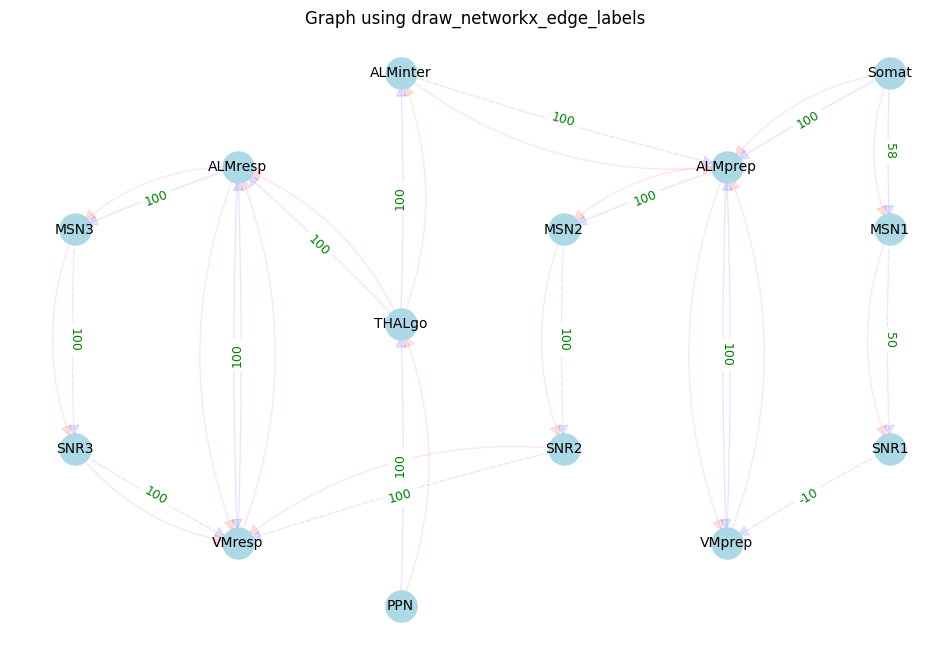

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Example custom node positions
neu_coords = {
    'Somat':   (5, 8.5),
    'MSN1':    (5, 6),
    'MSN2':    (3, 6),
    'MSN3':    (0, 6),
    'SNR1':    (5, 2.5),
    'SNR2':    (3, 2.5),
    'SNR3':    (0, 2.5),
    'ALMinter':(2, 8.5),
    'PPN':     (2, 0),
    'THALgo':  (2, 4.5),
    'VMprep':  (4, 1),
    'ALMprep': (4, 7),
    'ALMresp': (1, 7),
    'VMresp':  (1, 1)
}

# Create a MultiDiGraph
G = nx.MultiDiGraph()

# Add nodes
G.add_nodes_from(neu_coords.keys())

# Add edges from both lists. We use different edge attributes
# so we can later draw them with different colors and connection styles.
for i, (src, tgt) in enumerate(ACTIVE_SYNAPSES):
    # If the dna0 value is nonzero, add an edge for that
    if dna0[i] != 0:
        # Store the weight as an attribute, and tag as 'dna0'
        G.add_edge(src, tgt, weight=dna0[i], label=str(dna0[i]), edge_type='dna0')
    # If the percentage is > 48, add an edge for that
    if connection_percentages_string[i] > 48:
        # Tag these as 'pct'
        G.add_edge(src, tgt, weight=connection_percentages_string[i],
                   label=str(connection_percentages_string[i]), edge_type='pct')

# Create figure
plt.figure(figsize=(12, 8))

# Draw nodes and node labels
nx.draw_networkx_nodes(G, pos=neu_coords, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos=neu_coords, font_size=10)

# To draw edges separately by type (so we can use different curvature & colors),
# we iterate over all edges. For each edge, we choose a connection style.
# Note: draw_networkx_edge_labels will always use the straight line between nodes.
for u, v, key, d in G.edges(keys=True, data=True):
    # Set color based on edge type
    if d['edge_type'] == 'dna0':
        color = 'blue'
        # Use a moderate curvature for dna0 edges
        connection_style = 'arc3,rad=0.02'
    else:
        color = 'red'
        # Use a stronger curvature for percentage edges
        connection_style = 'arc3,rad=0.2'
        alpha = 0.1  # Make red arrows faint
    # Use dashed style for negative weights
    style = 'dashed' if d['weight'] < 0 else 'solid'
    
    # Draw this edge (each edge is drawn separately)
    nx.draw_networkx_edges(
        G,
        pos=neu_coords,
        edgelist=[(u, v)],
        connectionstyle=connection_style,
        edge_color=color,
        style=style,
        arrows=True,
        arrowsize=18,  # Shrink arrows by 10%
        alpha=alpha,  # Apply faintness to red arrows
        arrowstyle='-|>'
    )

# Build an edge_labels dictionary.
# Note: If there are multiple edges between the same pair of nodes,
# later entries will override earlier ones. For more complex cases,
# you might need to modify the keys to include the edge key.
edge_labels = {(u, v): d['label'] for u, v, key, d in G.edges(keys=True, data=True)}

# Now use draw_networkx_edge_labels to draw the labels.
# The label_pos parameter (0.5) places the label in the middle of the chord.
nx.draw_networkx_edge_labels(
    G,
    pos=neu_coords,
    edge_labels=edge_labels,
    font_color='green',
    font_size=9,
    label_pos=0.5
)

plt.title("Graph using draw_networkx_edge_labels")
plt.axis('off')
plt.show()


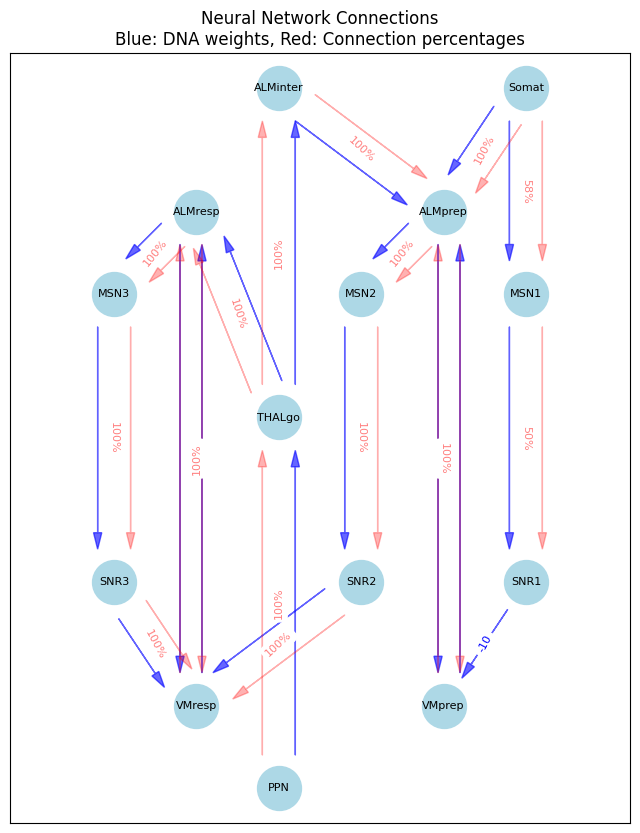

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Define custom positions for each node
neu_coords = {
    'Somat': (5, 8.5),
    'MSN1': (5, 6),
    'MSN2': (3, 6),
    'MSN3': (0, 6),
    'SNR1': (5, 2.5),
    'SNR2': (3, 2.5),
    'SNR3': (0, 2.5),
    'ALMinter': (2, 8.5),
    'PPN': (2, 0),
    'THALgo': (2, 4.5),
    'VMprep': (4, 1),
    'ALMprep': (4, 7),
    'ALMresp': (1, 7),
    'VMresp': (1, 1)
}

# Create two separate graphs for DNA and percentages
G_dna = nx.DiGraph()
G_percent = nx.DiGraph()

# Add nodes to both graphs
for node in neu_coords:
    G_dna.add_nodes_from(neu_coords.keys())
    G_percent.add_nodes_from(neu_coords.keys())

threshold = 50
# Add edges from DNA values (non-zero only)
for (source, target), weight in zip(ACTIVE_SYNAPSES, dna0):
    if weight != 0:
        G_dna.add_edge(source, target, weight=weight)

# Add edges from percentage values (non-zero only)
for (source, target), percent in zip(ACTIVE_SYNAPSES, connection_percentages_string):
    if percent >= threshold:
        G_percent.add_edge(source, target, weight=f'{percent}%')

def compute_edge_offsets(G1, G2, base_offset=0.2):
    """Compute offsets for all edges to avoid overlaps"""
    all_edges = {}
    
    # Group edges by their node pairs
    for u, v in G1.edges():
        key = tuple(sorted([u, v]))
        if key not in all_edges:
            all_edges[key] = []
        all_edges[key].append(('dna', u, v))
    
    for u, v in G2.edges():
        key = tuple(sorted([u, v]))
        if key not in all_edges:
            all_edges[key] = []
        all_edges[key].append(('percent', u, v))
    
    # Compute offsets
    edge_offsets = {}
    for edges in all_edges.values():
        n = len(edges)
        if n == 1:
            edge_offsets[edges[0]] = 0
        else:
            for i, edge in enumerate(edges):
                offset = -base_offset + (i * 2 * base_offset / (n - 1))
                edge_offsets[edge] = offset
    
    return edge_offsets

# Compute edge offsets
edge_offsets = compute_edge_offsets(G_dna, G_percent)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_node_boundary_point(start_pos, end_pos, node_radius=0.4):
    """Calculate where the edge should terminate at the node boundary"""
    direction = end_pos - start_pos
    length = np.linalg.norm(direction)
    if length == 0:
        return end_pos
    normalized_direction = direction / length
    boundary_point = end_pos - normalized_direction * node_radius
    return boundary_point

plt.figure(figsize=(8, 10))

# Draw DNA edges
for u, v, data in G_dna.edges(data=True):
    offset = edge_offsets[('dna', u, v)]
    start_pos = np.array(neu_coords[u])
    end_pos = np.array(neu_coords[v])
    
    # Calculate perpendicular offset
    direction = end_pos - start_pos
    perpendicular = np.array([-direction[1], direction[0]])
    perpendicular = perpendicular / np.linalg.norm(perpendicular) * offset
    
    # Apply offset to positions
    start_pos_offset = start_pos + perpendicular
    end_pos_offset = end_pos + perpendicular
    
    # Adjust start and end points to node boundaries
    start_boundary = get_node_boundary_point(end_pos_offset, start_pos_offset)
    end_boundary = get_node_boundary_point(start_pos_offset, end_pos_offset)
    
    # Draw edge
    plt.arrow(start_boundary[0], start_boundary[1],
              end_boundary[0] - start_boundary[0],
              end_boundary[1] - start_boundary[1],
              head_width=0.1, head_length=0.2, fc='blue', ec='blue',
              length_includes_head=True, alpha=0.6)
    
# Draw percentage edges
for u, v, data in G_percent.edges(data=True):
    offset = edge_offsets[('percent', u, v)]
    start_pos = np.array(neu_coords[u])
    end_pos = np.array(neu_coords[v])
    
    # Calculate perpendicular offset
    direction = end_pos - start_pos
    perpendicular = np.array([-direction[1], direction[0]])
    perpendicular = perpendicular / np.linalg.norm(perpendicular) * offset
    
    # Apply offset to positions
    start_pos_offset = start_pos + perpendicular
    end_pos_offset = end_pos + perpendicular
    
    # Adjust start and end points to node boundaries
    start_boundary = get_node_boundary_point(end_pos_offset, start_pos_offset)
    end_boundary = get_node_boundary_point(start_pos_offset, end_pos_offset)
    
    # Draw edge
    plt.arrow(start_boundary[0], start_boundary[1],
              end_boundary[0] - start_boundary[0],
              end_boundary[1] - start_boundary[1],
              head_width=0.1, head_length=0.2, fc='red', ec='red',
              length_includes_head=True, alpha=0.3)
    

# ... previous code remains the same until after drawing the edges ...

# Create label dictionaries for DNA and percentage edges
dna_labels = {(u, v): data['weight'] for u, v, data in G_dna.edges(data=True)}
percent_labels = {(u, v): data['weight'] for u, v, data in G_percent.edges(data=True)}

# Draw DNA edge labels
nx.draw_networkx_edge_labels(
    G_dna, 
    neu_coords,
    edge_labels=dna_labels,
    font_color='blue',
    font_size=8,
    label_pos=0.5  # Adjust this value (0.3 to 0.7) to fine-tune label position along edge
)

# Draw percentage edge labels
nx.draw_networkx_edge_labels(
    G_percent,
    neu_coords,
    edge_labels=percent_labels,
    font_color='red',
    font_size=8,
    alpha=0.5,
    label_pos=0.5  # Adjust this value (0.3 to 0.7) to fine-tune label position along edge
)

# ... rest of the code remains the same ...
# Draw nodes
for node, pos in neu_coords.items():
    plt.scatter(pos[0], pos[1], c='lightblue', s=1000, zorder=2)
    plt.text(pos[0], pos[1], node, horizontalalignment='center',
             verticalalignment='center', fontsize=8)

# Remove tick marks and adjust display
plt.tick_params(axis='both', which='both', length=0)
plt.xticks([])
plt.yticks([])

plt.title('Neural Network Connections\nBlue: DNA weights, Red: Connection percentages')
plt.axis('equal')
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
from collections import defaultdict
# Sort the DataFrame by dna_score (descending) and non_zero_count (ascending)
dg_df = fully_reduced_dnas.sort_values(['dna_score', 'non_zero_count'], ascending=[False, True])


# Define custom positions for each node
neu_coords = {
    'Somat': (5, 8.5),
    'MSN1': (5, 6),
    'MSN2': (3, 6),
    'MSN3': (0, 6),
    'SNR1': (5, 2.5),
    'SNR2': (3, 2.5),
    'SNR3': (0, 2.5),
    'ALMinter': (2, 8.5),
    'PPN': (2, 0),
    'THALgo': (2, 4.5),
    'VMprep': (4, 1),
    'ALMprep': (4, 7),
    'ALMresp': (1, 7),
    'VMresp': (1, 1)
}


# Assuming unique_df3 is already defined and contains the necessary data
# Ensure ACTIVE_SYNAPSES and NEURON_NAMES are defined in your context

# Calculate the number of DNAs
num_dnas = len(dg_df)

# Determine which connections are shared by more than 50% of the DNAs
shared_connections = np.zeros(len(ACTIVE_SYNAPSES), dtype=int)

for dna in dg_df['dna']:
    shared_connections += np.array([1 if weight != 0 else 0 for weight in dna])

# Identify connections shared by more than 50% of the DNAs
shared_threshold = num_dnas * 0.5
shared_indices = [i for i, count in enumerate(shared_connections) if count >= shared_threshold]

# Calculate proportion for each shared connection
shared_proportions = {i: shared_connections[i]/num_dnas for i in shared_indices}

# Function to determine the width of each edge
def get_edge_width(weight):
    return np.ceil(abs(weight) / 200) + 1

# Function to determine the style of each edge
def get_edge_style(weight):
    return 'dashed' if weight < 0 else 'solid'

def compute_edge_curvatures(G, base_curvature=0.2):
    """
    Compute distinct curvature values for each set of edges connecting the same two nodes.
    This groups reciprocal (or parallel) edges together and assigns curvatures spread evenly
    between -base_curvature and +base_curvature.
    """
    edge_curvatures = {}
    edge_groups = defaultdict(list)
    for u, v in G.edges():
        key = tuple(sorted((u, v)))
        edge_groups[key].append((u, v))
        
    for group in edge_groups.values():
        n = len(group)
        if n == 1:
            edge_curvatures[group[0]] = 0.0
        else:
            spacing = (2 * base_curvature) / (n - 1)
            for i, edge in enumerate(sorted(group)):
                edge_curvatures[edge] = -base_curvature + i * spacing
    return edge_curvatures


# Function to plot a specific configuration
def plot_configuration(config_index):
    dna = create_dna_string(jh_weights_with_E, ACTIVE_SYNAPSES)

    # Create a labeled Series for the DNA
    best_run_labeled = pd.Series(dna, index=[f"{pair[0]} -> {pair[1]}" for pair in ACTIVE_SYNAPSES])

    # Create a graph
    G = nx.DiGraph()

    # Add nodes for each neuron
    G.add_nodes_from(NEURON_NAMES)

    # Add edges for non-zero synaptic connections
    for synapse, weight in best_run_labeled.items():
        if weight != 0:
            source, target = synapse.split(' -> ')
            G.add_edge(source, target, weight=weight)

    edge_curvatures = compute_edge_curvatures(G, base_curvature=0.2)
    

    # Draw the main graph using the custom positions
    plt.figure(figsize=(10, 6))
    edges = G.edges(data=True)

    for (u, v) in G.edges():
        rad = edge_curvatures[(u, v)]
        nx.draw_networkx_edges(
            G, pos=neu_coords, edgelist=[(u, v)],
            connectionstyle=f'arc3,rad={rad}',
            arrows=True, arrowstyle='-|>', arrowsize=20,
            width=get_edge_width(G[u][v]['weight']),
            style=get_edge_style(G[u][v]['weight']),
            edge_color='black'
        )
    # Create offset positions for shared connections
    offset_pos = neu_coords.copy()
    offset = 0.18  # Adjust this value to control the offset amount
    
    # Add shared connections in red with offset and arrows
    for index in shared_indices:
        source, target = ACTIVE_SYNAPSES[index]
        # Calculate offset positions
        source_pos = np.array(neu_coords[source])
        target_pos = np.array(neu_coords[target])
        # Add perpendicular offset
        direction = target_pos - source_pos
        perpendicular = np.array([-direction[1], direction[0]])
        perpendicular = perpendicular / np.linalg.norm(perpendicular) * offset
        
        # Shrink the arrow length by 20%
        midpoint = source_pos + 0.5 * direction
        source_pos_adjusted = midpoint - 0.4 * direction  # Move start point 10% closer to midpoint
        target_pos_adjusted = midpoint + 0.4 * direction  # Move end point 10% closer to midpoint
        
        offset_pos[source] = tuple(source_pos_adjusted + perpendicular)
        offset_pos[target] = tuple(target_pos_adjusted + perpendicular)
        
        # Draw red arrows with arrowheads and transparency
        nx.draw_networkx_edges(G, pos=offset_pos, edgelist=[(source, target)], 
                             edge_color='red', width=2, arrows=True, arrowsize=20, alpha=0.1)
        
        # Add proportion label to the red edges
        edge_labels = {(source, target): f'{shared_proportions[index]:.0%}'}
        nx.draw_networkx_edge_labels(G, pos=offset_pos, edge_labels=edge_labels, 
                                   font_color='red', font_size=8, alpha=0.5)

        # Draw reciprocal connection as a separate arrow
        if G.has_edge(target, source):
            reciprocal_weight = G[target][source]['weight']
            nx.draw_networkx_edges(G, pos=offset_pos, edgelist=[(target, source)], 
                                 edge_color='orange', width=2, arrows=True, arrowsize=20, alpha=0.1)

    # # Highlight non-shared connections in blue
    # non_shared_edges = [(source, target) for i, (source, target) in enumerate(ACTIVE_SYNAPSES) if i not in shared_indices and G.has_edge(source, target)]
    # nx.draw_networkx_edges(G, pos=custom_pos, edgelist=non_shared_edges, edge_color='blue', width=2, style='dashed')

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=neu_coords, edge_labels=edge_labels, font_color='gray',font_size=8)

    plt.title('Synaptic Connections: Shared (Red) vs Non-Shared (Blue) vs Reciprocal (Orange)')
    plt.show()

# Create an interactive slider to flip through the configurations
interact(plot_configuration, config_index=IntSlider(min=0, max=len(dg_df)-1, step=1, value=0))

ValueError: operands could not be broadcast together with shapes (9,) (49,) (9,) 